In [22]:
import Pkg
Pkg.activate("../src/FE_v0.1/Project.toml")

# using Pkg; Pkg.add("Measures")
# using Pkg; Pkg.add("JLD2")
# Pkg.add("FiniteElements")
# Pkg.add("OrdinaryDiffEq")
# import Pkg; Pkg.add("FiniteElements")
import OrdinaryDiffEq as ODE

using QuadGK
using BasicBSpline
using Random
using Distributions
using LaTeXStrings
using Plots #, CairoMakie
using PyPlot
using Printf
using SparseArrays

using FiniteElements
using Base.Threads
using Plots.PlotMeasures
using Statistics

using LinearAlgebra # identity matrix
using Turing # sampling package
using StatsPlots
using StatsBase # for defining customized distributions 
using Optim # for ML and MAP estimation 
using AdaptiveMCMC # for using adaptive MCMC sampling
using ProgressMeter # to use progress track for sampling
using Dates # to measure computational time 
using FlexiMaps # Provide flexible mapping functionalities, particularly useful for data processing tasks

using JLD2 # to save results and reuse them
using Measures

include("../src/SIACMatrix_v2.jl")
include("../src/FE_v0.1/src/DG.jl")

results_dir = "results_section_6_2"

  Activating project at `~/Desktop/UMBC/240801BayesianSIAC/code/250902code_TL/src/FE_v0.1`
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.


"results_section_6_2"

Setting up the Domain and the Mesh

In [23]:
# Setting up Domain Parameters
xL = -1.0       # Left Domain Boundary
xR = 1.0        # Right Domain Boundary

# Setting up the Mesh-series
# IMPORTANT: For now need numEl>=10 for the base mesh, to construct SIAC matrix!!
pMax = 3            # largest polynomial degree used (sets up DG approximation with degree 1:pMax)
refine = 4          # Number of meshes (refine=1 means the base mesh is refined once, and there are two meshes)
numEl = 3*pMax+1    # Number of Elements in Base Mesh (Choosen such that on each mesh, the filter crosses the Boundary at max once)


mesh = Array{FiniteElements.Mesh}(undef, refine) # Mesh Data structure

# Mesh Info
dim = 1
ElemsPerDim = [numEl]
mesh_vertices = [xL xR]

# Creating the meshes
for m=1:refine
    mesh[m] = build_cube_mesh(mesh_vertices, ElemsPerDim*(2^(m-1)), dim)
end

Setting up the equation, the initial conditions, and the SIAC Matrices

In [24]:
# Initial Condition
u0(x) = 1 + .5*sin.(pi*x) # + 0.3*cos(pi*x) - 0.4*sin(2pi*x)

# Evaluation Nodes, for which the SIAC MAtrix is constructed
Nodes = Array{Array{Float64}}(undef,refine,pMax)        # Global evaluation Points 
w_Nodes_global = Array{Array{Float64}}(undef,refine,pMax)        # Global Quadrature Weigths
Nodes_loc = Array{Array{Float64}}(undef,refine,pMax)    # Local Evaluation points
w_Nodes_local = Array{Array{Float64}}(undef,refine,pMax)        # Local Quadrature Weigths
numNodes = zeros(Int,refine,pMax)     # number of evaluation points 


xEval = Array{Array{Float64}}(undef,refine,pMax)        # Global evaluation Points 
w_global = Array{Array{Float64}}(undef,refine,pMax)        # Global Quadrature Weigths
xEval_loc = Array{Array{Float64}}(undef,refine,pMax)    # Local Evaluation points
w_local = Array{Array{Float64}}(undef,refine,pMax)        # Local Quadrature Weigths
nEval = zeros(Int,refine,pMax)     # number of evaluation points 

# Available Node types:
# "GLeg"    Gauss-Legendre nodes
# "GLob"    Gauss-Lobatto nodes
# "uni"     Equidistant nodes
# "L2"      no Interpolation, chooses L2_projection
EvalType = "L2"   


# Setting up DoF handles, for Mesh series and different polynomial degrees
uh = Array{FE}(undef, refine, pMax)     # DG data structure

# Declaring Evaluation handles
# uh_ev and u0_ev evaluate uh and u at the points prescribed in xEval.
u0_ev =  Array{Vector}(undef,refine,pMax)   # True solution (for different refinements and degrees)
uh_Nodal = Array{Vector}(undef,refine,pMax)    # DG Initial Condition (for different refinements and degrees)
uh_ev = Array{Vector}(undef,refine,pMax)    # DG Initial Condition (for different refinements and degrees)
uh_ev_pp = Array{Vector}(undef,refine,pMax) # DG Initial Condition, SIAC filtered (for different refinements and degrees)


# SIAC Matrices
F  = Array{Matrix}(undef,refine,pMax)
F_ev  = Array{Matrix}(undef,refine,pMax)

# Initializing Evaluation handles, IC and SIAC matrices
for m=1:refine
    for p=1:pMax

        if EvalType=="L2"
            Nodes[m,p], w_global[m,p], Nodes_loc[m,p], w_local[m,p] = makeNodes(mesh[m], p, type="GLeg") # Gauss-Legendre Evaluation nodes
            numNodes[m,p] = length(Nodes[m,p])

            xEval[m,p], ~, xEval_loc[m,p], ~ = makeNodes(mesh[m], 10, type="GLeg") # Gauss-Legendre Evaluation nodes
            nEval[m,p] = length(xEval[m,p])


            uh[m,p] = L2(u0, mesh[m], p, dim)
        else
            Nodes[m,p], w_global[m,p], Nodes_loc[m,p], w_local[m,p] = makeNodes(mesh[m], p, type=EvalType) # Nodes
            numNodes[m,p] = length(Nodes[m,p])

            xEval[m,p], ~, xEval_loc[m,p], ~ = makeNodes(mesh[m], 10, type="GLeg") # Gauss-Legendre Evaluation nodes
            nEval[m,p] = length(xEval[m,p])


            uh[m,p] =  Interpolate(u0, mesh[m],xEval_loc[m,p], p, dim)
        end

        uh_Nodal[m,p] = [evalFE(Nodes[m,p][j],uh[m,p]) for j=1:numNodes[m,p]]

        uh_ev[m,p] = [evalFE(xEval[m,p][j],uh[m,p]) for j=1:nEval[m,p]]
        u0_ev[m,p] = [u0(xEval[refine,pMax][j]) for j=1:nEval[refine,pMax]]

        # Initializing the SIAC matrices
        # F[m,p] is a quadratic matrix, used to postprocess uh_ev[m,p]
        # boundaryTreatment="none"      : Default, leaves near-boundary region unchanged
        # boundaryTreatment="periodic"  : Assumes periodic boundary
        F[m,p] = global_SIAC_Mat(p, mesh[m].NC[], Nodes_loc[m,p], Nodes_loc[m,p]; boundaryTreatment="periodic")    # square SIAC Matrix 
        F_ev[m,p] = global_SIAC_Mat(p, mesh[m].NC[], Nodes_loc[m,p], xEval_loc[m,p]; boundaryTreatment="periodic") # Evaluation SIAC Matrix
        uh_ev_pp[m,p] =  F_ev[m,p]*uh_Nodal[m,p]  # SIAC Filtered IC

    end
end

Visualizing the Initial Condition

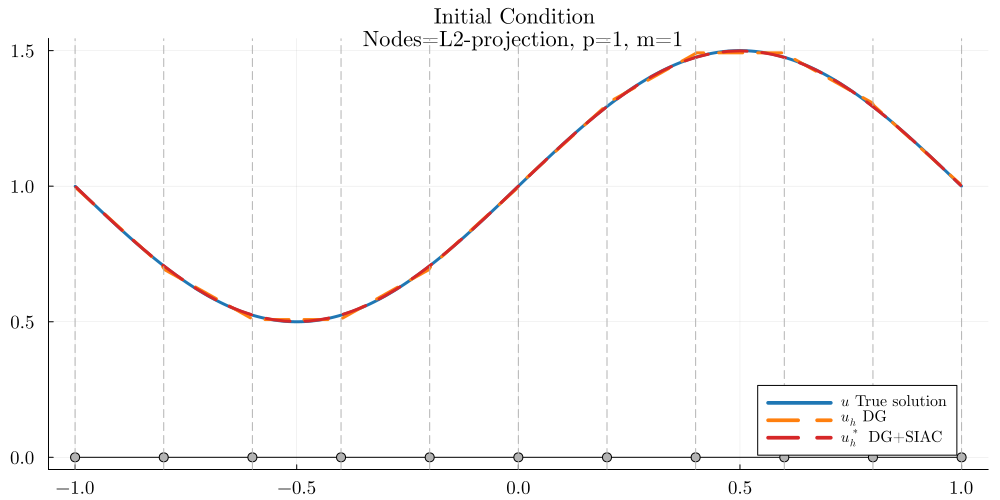

In [25]:
p = 1  # Polynomial degree
m = 1 # Mesh refinment level

# Plotting utility
node_name = "Nodes"
if EvalType == "GLeg"
        node_name  = "Gauss-Legendre"
elseif EvalType == "GLob"
        node_name  = "Gauss-Lobatto"
elseif EvalType == "uni"
        node_name  = "Equidistant"
elseif EvalType == "L2"
        node_name  = "L2-projection"
end

plot_font = "Computer Modern"
pex=Plots.plot(size=(1000,500),
            fontfamily=plot_font,
            title=@sprintf("Initial Condition \n Nodes=%s, p=%d, m=%d",node_name,p,m),
            legend=:bottomright,
            tickfontsize=12,
            labelfontsize=12,
            legendfontsize=10 )
Plots.plot!(xEval[refine,pMax],u0_ev[refine,pMax],label=L"$u$ True solution", lw=3, color=palette(:tab10)[1])
Plots.plot!(pex, xEval[m,p], uh_ev[m,p]; label=L"$u_h$ DG",lw=3, ls=:dash, color=palette(:tab10)[2])
Plots.plot!(pex, xEval[m,p], F_ev[m,p]*uh_Nodal[m,p]; label=L"$u_h^*$ DG+SIAC",lw=3, ls=:dash, color=palette(:tab10)[4])

for i = 1:mesh[m].NE[]-1
    Plots.plot!( [mesh[m].edges[i].vertices[1],mesh[m].edges[i+1].vertices[1]], [0,0], color=:black, lw=1, label="")
end
Plots.scatter!(mesh[m].vertices, zeros(1,mesh[m].NV[]) , label="", color=:grey70, markersize = 5)
Plots.vline!(pex, mesh[m].vertices,color=:grey70,ls=:dash,label="",lw = 1)

Setting up the Discretization 

In [26]:
# Evaluation Handles
globalDoFs = Array{Vector}(undef, refine, pMax)         # Stores the DoF of the IC. globalDoFs[m,p] are the DoFs of uh[m,p], used for time stepping
discretization = Array{Function}(undef, refine, pMax)   # The spatial (DG) discretization

# Evaluation stuff
globalDoFs_final = Array{Vector}(undef, refine, pMax)   # Stores the DoF of the final state. 
uh_Nodal_final = Array{Vector}(undef,refine,pMax)          # Evaluation points for the final state 

uh_ev_final = Array{Vector}(undef,refine,pMax)          # Evaluation points for the final state 
uh_ev_final_pp = Array{Vector}(undef,refine,pMax)       # Evaluation points for the final state 


# define the Advection velocity
alpha = [1.0]  # Advection velocity

# Declare Discretization of differential operators
M_fac = Array{Union{Diagonal{Float64, SparseVector{Float64,Int}},Factorization}}(undef, refine, pMax)        # Factorized Mass Matrix
A = Array{Matrix}(undef, refine, pMax)          # Advection + Boundary Matrix

# Assembling the spatial discretization
for m=1:refine
    for p=1:pMax

        # Uncomment to reinitialize DG-handles
        if EvalType=="L2"
            uh[m,p] = L2(u0, mesh[m], p, dim)
        else
            uh[m,p] =  Interpolate(u0, mesh[m],xEval_loc[m,p], p, dim)
        end

        # Get DoFs from DG-handle
        globalDoFs[m,p] = getDoF(uh[m,p])
        
        M = assemble_BilinearForm(uh[m,p],dim,"Base_Base")             # Mass Matrix
        K = assemble_BilinearForm(uh[m,p],dim,"Grad_Base",field=alpha) # Advection Matrix

        # (periodic) Outlet/do-nothing BC
        Bd = assembleBoundaryMatrix(uh[m,p], 2, dim) # Outlet 

        # Discrtization Matrix + factorization
        A[m,p] = (K-Bd)
        M_fac[m,p] = factorize(M)

        # Discretized PDE
        discretization[m,p] = (dummyDoF,_,ts) -> M_fac[m,p]\(A[m,p]*dummyDoF + prescribeBoundaryData(uh[m,p], 1, dim, x->u0(x-ts); field=alpha))
    end
end

Assembling Advection Matrix (Face Contribution).. 100%|██| Time: 0:00:00


Time Stepping

In [27]:
# Set final time
t_end = 1.0

## RK4 time integration -> needs very high tolerance
# # Time stepping for all degees & refinements
# for m=1:refine
#     for p=1:pMax
#
#         # Set up ODE solver
#         prob = ODE.ODEProblem(discretization[m,p], globalDoFs[m,p], (0,t_end))
#         sol = ODE.solve(prob, ODE.Rk4())

#         # Update DoFs and evaluation points
#         setDoF!(uh[m,p],sol.u[end])
#         uh_Nodal_final[m,p] = [evalFE(Nodes[m,p][j],uh[m,p]) for j=1:numNodes[m,p]]
#         uh_ev_final[m,p] = [evalFE(xEval[m,p][j],uh[m,p]) for j=1:nEval[m,p]]

#         # Get SIAC Matrix for final State
#         uh_ev_final_pp[m,p] =  F_ev[m,p]*uh_Nodal_final[m,p]
#     end
# end


## Verner Time Integration
for m=1:refine
    for p=1:pMax

        # Set up ODE solver
        prob = ODE.ODEProblem(discretization[m,p], globalDoFs[m,p], (0,t_end))
        sol = ODE.solve(prob, ODE.Vern9())

        # Update DoFs and evaluation points
        setDoF!(uh[m,p],sol.u[end])
        uh_Nodal_final[m,p] = [evalFE(Nodes[m,p][j],uh[m,p]) for j=1:numNodes[m,p]]
        uh_ev_final[m,p] = [evalFE(xEval[m,p][j],uh[m,p]) for j=1:nEval[m,p]]

        # Get SIAC Matrix for final State
        uh_ev_final_pp[m,p] =  F_ev[m,p]*uh_Nodal_final[m,p]
    end
end
   

In [43]:
# save variables of interests
# jldopen("results_DG_T1.jld2", "w") do file
jldopen(joinpath(results_dir, "results_DG_T1.jld2"), "w") do file
    write(file, "uh_ev_final", uh_ev_final)
    write(file, "uh_Nodal_final", uh_Nodal_final)
    write(file, "uh_ev_final_pp", uh_ev_final_pp)
end

Visualize the final State

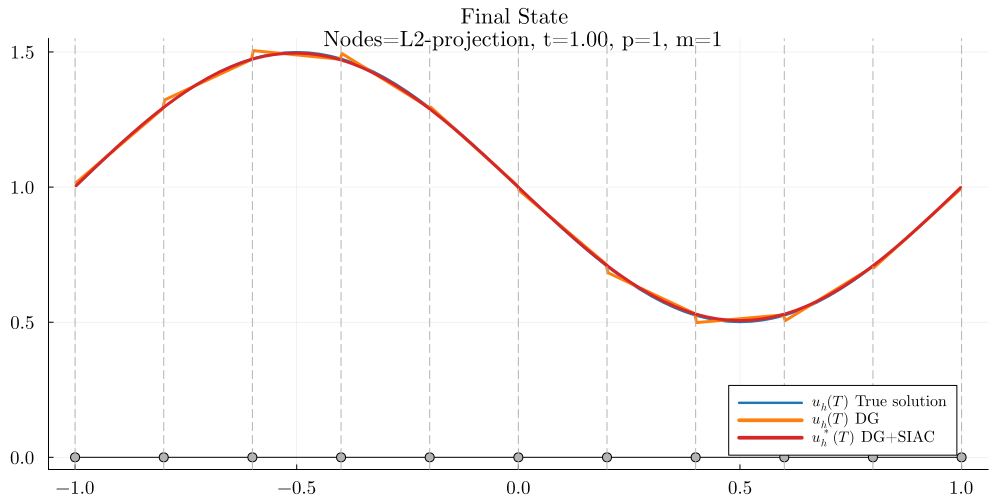

In [44]:
p = 1 # Polynomial degree
m = 1   # Mesh refinment level

u_final= [u0(xEval[m,p][j]-t_end) for j=1:nEval[m,p]]

# Plotting utility
node_name = "Nodes"
if EvalType == "GLeg"
        node_name  = "Gauss-Legendre"
elseif EvalType == "GLob"
        node_name  = "Gauss-Lobatto"
elseif EvalType == "uni"
        node_name  = "Equidistant"
elseif EvalType == "L2"
        node_name  = "L2-projection"
end

plot_font = "Computer Modern"
pex=Plots.plot(size=(1000,500),
        fontfamily=plot_font,
        title=@sprintf("Final State \n Nodes=%s, t=%2.2f, p=%d, m=%d",node_name,t_end,p,m),
        legend=:bottomright,
        tickfontsize=12,
        labelfontsize=12,
        legendfontsize=10 )
Plots.plot!(xEval[m,p],u_final;label=L"$u_h(T)$ True solution",lw=2, ls=:solid, color=palette(:tab10)[1])
Plots.plot!(xEval[m,p],uh_ev_final[m,p],label=L"$u_h(T)$ DG", lw=3, color=palette(:tab10)[2])
Plots.plot!(xEval[m,p], uh_ev_final_pp[m,p]; label=L"$u_h^*(T)$ DG+SIAC",lw=3, color=palette(:tab10)[4])

# Plots.plot!(xEval[m,p],u_final-uh_ev_final[m,p],label=L"$u_h(T)$ DG", lw=3,ls=:dash, color=palette(:tab10)[2])
# Plots.plot!(xEval2[m,p],u_final2-uh_ev_final_pp[m,p]; label=L"$u_h^*(T)$ DG+SIAC",lw=3, ls=:dash, color=palette(:tab10)[4])

for i = 1:mesh[m].NE[]-1
    Plots.plot!( [mesh[m].edges[i].vertices[1],mesh[m].edges[i+1].vertices[1]], [0,0], color=:black, lw=1, label="")
end
Plots.scatter!(mesh[m].vertices, zeros(1,mesh[m].NV[]) , label="", color=:grey70, markersize = 5)
Plots.vline!(pex, mesh[m].vertices,color=:grey70,ls=:dash,label="",lw = 1)

Computing Errors for the Convergence Study

In [45]:
# Error at the final time (as function evaluation)
eh = Array{Vector}(undef,refine,pMax)
eh_pp = Array{Vector}(undef,refine,pMax)

# Error norm at final time
err = zeros(refine,pMax)
err_pp = zeros(refine,pMax)

# Mesh sizes
h_ref = zeros(refine)


plot_font = "Computer Modern"
for m=1:refine
    # set reference mesh size (assuming uniform mesh)
    h_ref[m] = (mesh[m].vertices[2]-mesh[m].vertices[1])
    for p=1:pMax

        u_final = [u0(Nodes[m,p][j]-t_end) for j=1:numNodes[m,p]]

        # Compute error function
        eh[m,p] = zeros(numNodes[m,p])
        eh_pp[m,p] = zeros(numNodes[m,p])

        for j=1:numNodes[m,p]
            eh[m,p][j] = u_final[j]-uh_Nodal_final[m,p][j]
            eh_pp[m,p][j] = u_final[j]-(F[m,p]*uh_Nodal_final[m,p])[j]
        end

        # Compute error norm
        err[m,p] = sqrt(sum(eh[m,p].^2 .* w_global[m,p])/(mesh[m].NC[])) 
        err_pp[m,p] = sqrt(sum(eh_pp[m,p].^2 .* w_global[m,p])/(mesh[m].NC[]))
    end
end


In [46]:
# save more variables of interest
jldopen(joinpath(results_dir, "results_DG_T1.jld2"), "r+") do file
    write(file, "h_ref", h_ref)
    write(file, "err", err)
    write(file, "err_pp", err_pp)
end

Visulaizing the Convergence Study

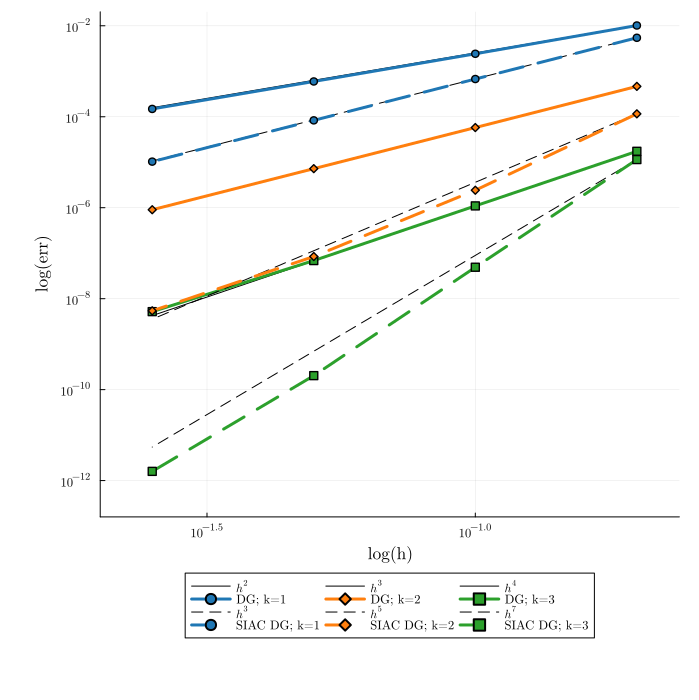

"results_section_6_2/Convergence_SIAC_T1.pdf"

In [47]:
# Visualization of Convergence Properties
XTick = [10.0^(ll) for ll=1:-0.5:-2]
YTick = [10.0^(ll) for ll=2:-2:-12]
colors = palette(:tab10)
markers = [:circ :diamond :square]

yMax =  2*maximum([err;err_pp])
yMin = 0.1*minimum([err;err_pp])

xMax = 1.2*maximum(h_ref)
xMin = 0.8*minimum(h_ref)

xs = [10e-1 maximum(h_ref)]

plt = Plots.plot(yscale=:log10, 
                        yticks=YTick, 
                        ylims=(yMin, yMax),
                        xscale=:log10, 
                        xticks=XTick, 
                        xlims=(xMin, xMax),
                        xlabel="log(h)",
                        ylabel="log(err)")

for k = 1:pMax
    c1 =  (err[1,k]/h_ref[1]^(k+1)) # Constant to adjust the reference line
    Plots.plot!(h_ref[:], t-> c1*t^(k+1), color=:black, label=latexstring(" h^{$(k+1)}"))
end
for k = 1:pMax
    Plots.plot!(h_ref[:], err[:,k], color=colors[k], lw=3, marker=markers[k],label=@sprintf("DG; k=%d",k))
end

for k = 1:pMax
    c2 =  (err_pp[1,k]/h_ref[1]^(2k+1)) # Constant to adjust the reference line
    Plots.plot!(h_ref[:], t->c2*t^(2k+1), color=:black, ls=:dash,label=latexstring(" h^{$(2k+1)}"))
end
for k = 1:pMax
    Plots.plot!(h_ref[:], err_pp[:,k], color=colors[k], lw=3, ls=:dash, marker=markers[k], label=@sprintf("SIAC DG; k=%d",k))
end


FIG = Plots.plot(plt,
        fontfamily=plot_font, 
        legend=:outerbottom,
        size=(700,700), 
        left_margin=8mm,
        right_margin=3mm,
        bottom_margin=1mm,
        legend_columns=3) 
# Plots.pdf(FIG,"Convergence_SIAC_new")

# Display the plot
display(FIG)
Plots.pdf(FIG,joinpath(results_dir, "Convergence_SIAC_T1"))

### Post-processing: check errors and order of convergence

In [48]:
# check results stored before
jldopen(joinpath(results_dir, "results_DG_T1.jld2"), "r") do file
    println("Variables stored in the file:")
    println(keys(file))
end

Variables stored in the file:
["uh_ev_final", "uh_Nodal_final", "uh_ev_final_pp", "h_ref", "err", "err_pp"]


In [50]:
# Load results
@load joinpath(results_dir, "results_DG_T1.jld2") h_ref err err_pp

3-element Vector{Symbol}:
 :h_ref
 :err
 :err_pp

In [51]:
refine = 4

4

In [52]:
println("DG Errors for p=1:")
for m in 1:refine
    println("m=$m, h=$(h_ref[m]): err=$(err[m, 1])")
end

DG Errors for p=1:
m=1, h=0.19999999999999996: err=0.010150195404108962
m=2, h=0.09999999999999998: err=0.0024246276474011452
m=3, h=0.050000000000000044: err=0.0005969722581727836
m=4, h=0.025000000000000022: err=0.00014861176053423348


In [53]:
orders = zeros(refine-1)
for m in 1:refine-1
    e1, e2 = err[m,1], err[m+1,1]
    h1, h2 = h_ref[m], h_ref[m+1]
    orders[m] = log(e1/e2) / log(h1/h2)
end

In [54]:
println("\nEstimated DG orders of convergence (between consecutive mesh refinements):")
for m in 1:refine-1
    println("Between m=$m and m=$(m+1): order=$(orders[m])")
end


Estimated DG orders of convergence (between consecutive mesh refinements):
Between m=1 and m=2: order=2.0656723881438728
Between m=2 and m=3: order=2.0220274132770837
Between m=3 and m=4: order=2.0061156002869414


In [55]:
println("DG SIAC Errors for p=1:")
for m in 1:refine
    println("m=$m, h=$(h_ref[m]): err=$(err_pp[m, 1])")
end

DG SIAC Errors for p=1:
m=1, h=0.19999999999999996: err=0.005449531315635482
m=2, h=0.09999999999999998: err=0.0006754424772828953
m=3, h=0.050000000000000044: err=8.333027916542898e-5
m=4, h=0.025000000000000022: err=1.0314262644873149e-5


In [56]:
orders = zeros(refine-1)
for m in 1:refine-1
    e1, e2 = err_pp[m,1], err_pp[m+1,1]
    h1, h2 = h_ref[m], h_ref[m+1]
    orders[m] = log(e1/e2) / log(h1/h2)
end

In [57]:
println("\nEstimated DG SIAC orders of convergence (between consecutive mesh refinements):")
for m in 1:refine-1
    println("Between m=$m and m=$(m+1): order=$(orders[m])")
end


Estimated DG SIAC orders of convergence (between consecutive mesh refinements):
Between m=1 and m=2: order=3.0122273412827774
Between m=2 and m=3: order=3.0189201921219673
Between m=3 and m=4: order=3.0142001250377315


In [58]:
orders = [ log(err[m-1,p]/err[m,p])/log(2) for m=2:4, p=1:pMax]
orders_pp = [ log(err_pp[m-1,p]/err_pp[m,p])/log(2) for m=2:4, p=1:pMax]

display(orders)
display(orders_pp)

display(err)
display(err_pp)

3×3 Matrix{Float64}:
 2.06567  3.00814  3.98654
 2.02203  3.00191  3.99337
 2.00612  3.00047  3.73187

3×3 Matrix{Float64}:
 3.01223  5.5798   7.86636
 3.01892  4.84132  7.9165
 3.0142   3.96632  6.9936

4×3 Matrix{Float64}:
 0.0101502    0.000465652  1.7392e-5
 0.00242463   5.7879e-5    1.09719e-6
 0.000596972  7.22529e-6   6.88904e-8
 0.000148612  9.02865e-7   5.18507e-9

4×3 Matrix{Float64}:
 0.00544953   0.00011591  1.1451e-5
 0.000675442  2.42345e-6  4.90719e-8
 8.33303e-5   8.45381e-8  2.03109e-10
 1.03143e-5   5.40844e-9  1.59385e-12